# Intro

Weights adjustment:

$$ W = \underset{W}{\text{arg min}} \;J $$

* Weights are initialized as random nums and adjusted during learning
* How learning affects the dist of the weights?

In [34]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
from sklearn.model_selection import train_test_split

# Data

In [35]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')

labels = data[:,0]
data = data[:, 1:]

labels = torch.tensor(labels, dtype = torch.long)
data = torch.tensor(data, dtype = torch.float)
data_norm = data / torch.max(data)

labels, data_norm

(tensor([6, 5, 7,  ..., 2, 9, 5]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

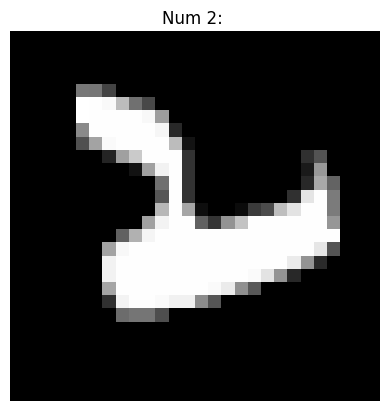

In [36]:
rand_row = np.random.randint(data.shape[0])
img = np.reshape(data_norm[rand_row], (28,28))
num = labels[rand_row]

plt.imshow(img, cmap = 'grey')
plt.title('Num %d: '%num)
plt.axis(False)
plt.show()

# Split

In [37]:
train_data, test_data, train_labels, test_labels = train_test_split(data_norm, labels, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

# Model

In [38]:
data.shape

torch.Size([20000, 784])

In [39]:
def ModelCreate():
  class ModelArch(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(784, 32)
      self.f1 = nn.Linear(32, 16)
      self.f2 = nn.Linear(16, 16)
      self.output = nn.Linear(16, 10)

    def forward(self, x):
      x = F.relu(self.input(x))
      x = F.relu(self.f1(x))
      x = F.relu(self.f2(x))
      x = self.output(x)
      return x

  ann = ModelArch()
  loss_fn = nn.CrossEntropyLoss()
  optim = torch.optim.SGD(ann.parameters(), lr = 1e-2)

  return ann, loss_fn, optim

In [40]:
ann, loss_fn, optim = ModelCreate()
ann

ModelArch(
  (input): Linear(in_features=784, out_features=32, bias=True)
  (f1): Linear(in_features=32, out_features=16, bias=True)
  (f2): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=10, bias=True)
)

In [41]:
X, y = next(iter(data_norm)), next(iter(labels))
y_hat = ann(X)
loss = loss_fn(y_hat, y)
print(f'Test sping loss: {loss.item():.4f}')

Test sping loss: 2.1352


# Model Innards

## Initial Layers' Weights Distributions

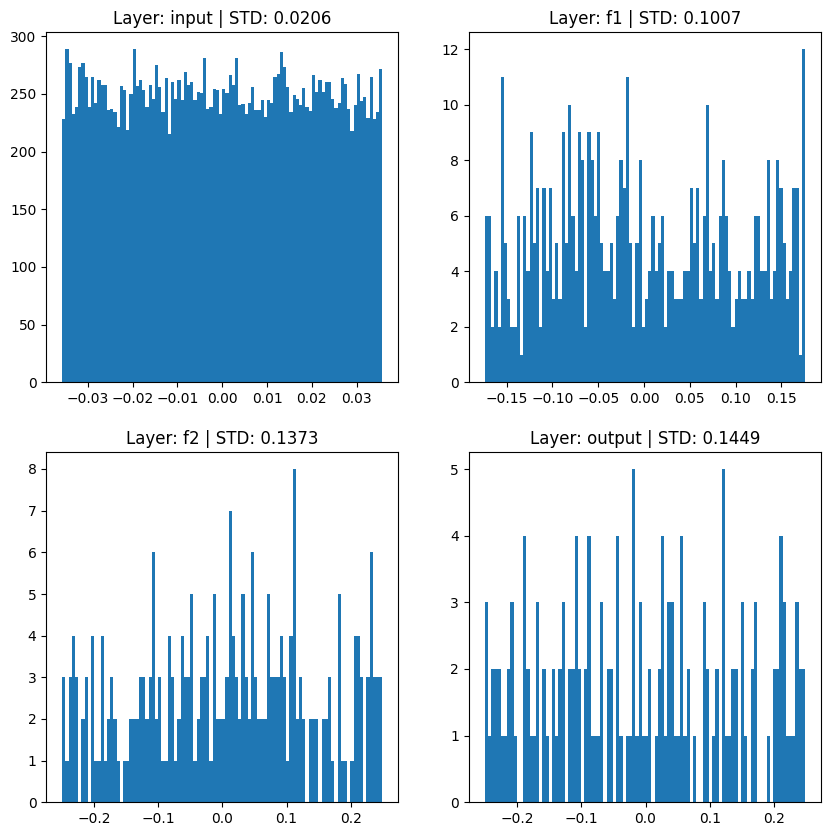

In [42]:
fig, axs = plt.subplots(2,2,figsize = (10,10))

layer_names = ['input', 'f1', 'f2', 'output']
weights = [weights for name, weights in ann.named_parameters() if 'weight' in name and 'bias' not in name]
layer_names = iter(layer_names)
weights = iter(weights)

for ax in axs.flatten():
  name = next(layer_names)
  weight = next(weights)
  ax.hist(weight.detach().flatten(), 100)
  ax.set_title(f'Layer: {name} | STD: {torch.std(weight):.4f}')

We can see that first layer has no diversity in weights, the more we go further standard deviation gets higher, since weights are getting adjusted.

## Weights Dynamics

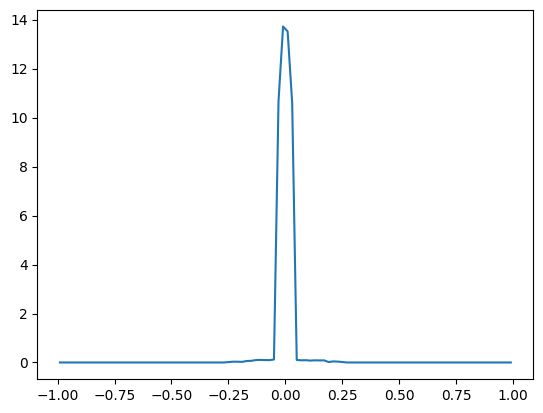

In [43]:
def weights_hist(ann):

  W = np.array([])

  for weights in ann.parameters():
    W = np.concatenate((W, weights.detach().flatten().numpy()))

  hist_y, hist_x = np.histogram(W, bins = np.linspace(-1,1,101), density = True)
  hist_x = (hist_x[1:] + hist_x[:-1])/2

  return hist_x, hist_y

hist_x, hist_y = weights_hist(ann)

plt.plot(hist_x, hist_y)
plt.show()

## Model Train

In [44]:
def ModelTrain(epochs, verbose):
  net, loss_fn, optimizer = ModelCreate()

  losses = torch.zeros(epochs)
  train_accs = []
  test_accs = []

  hist_x = np.zeros((epochs, 100))
  hist_y = np.zeros((epochs, 100))

  for epoch in range(epochs):
    net.train()

    batch_acc = []
    batch_loss = []

    hist_x, hist_y[epoch,:] =  weights_hist(net)

    for X, y in train_dataloader:

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100 * torch.mean(matches_numeric)
      batch_acc.append(accuracy_pct)
    # end of batch loop

    #training accuracy
    train_acc = np.mean(batch_acc)
    train_accs.append(train_acc)

    # and get  avg losses
    losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(test_dataloader))
    with torch.no_grad(): # deactivates autograd
      y_hat = net(X)

    test_acc = 100 * torch.mean((torch.argmax(y_hat, axis = 1) == y).float())
    test_accs.append(test_acc)
  # end epochs

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch} | Train Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f} | Loss: {losses[epoch]:.2f}')

  return train_accs, test_accs, losses, hist_x, hist_y

In [45]:
train_accs, test_accs, losses, hist_x, hist_y = ModelTrain(epochs = 100, verbose = True)

Epoch: 0 | Train Acc: 9.79 | Test Acc: 9.90 | Loss: 2.30
Epoch: 10 | Train Acc: 85.20 | Test Acc: 85.28 | Loss: 0.51
Epoch: 20 | Train Acc: 90.43 | Test Acc: 90.30 | Loss: 0.33
Epoch: 30 | Train Acc: 92.74 | Test Acc: 92.15 | Loss: 0.25
Epoch: 40 | Train Acc: 94.48 | Test Acc: 92.90 | Loss: 0.19
Epoch: 50 | Train Acc: 95.76 | Test Acc: 93.47 | Loss: 0.15
Epoch: 60 | Train Acc: 96.60 | Test Acc: 93.55 | Loss: 0.12
Epoch: 70 | Train Acc: 97.18 | Test Acc: 94.22 | Loss: 0.10
Epoch: 80 | Train Acc: 97.83 | Test Acc: 94.03 | Loss: 0.08
Epoch: 90 | Train Acc: 98.33 | Test Acc: 94.17 | Loss: 0.07


## Plots

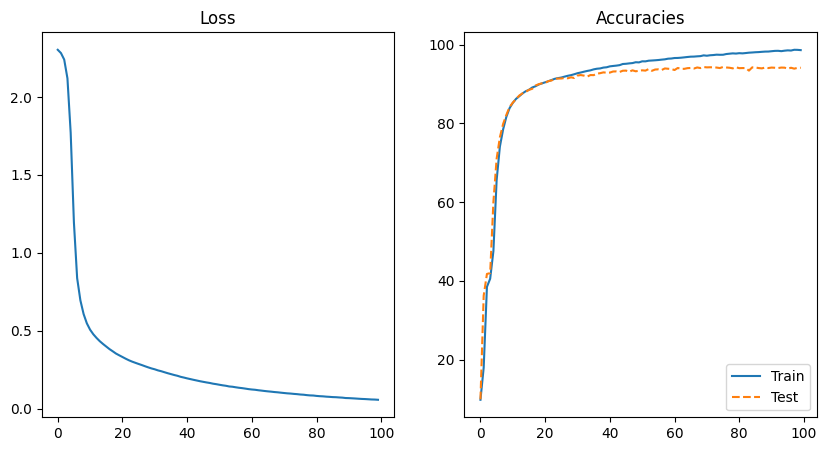

In [46]:
fig, ax = plt.subplots(1,2,figsize = (10,5))

ax[0].plot(losses)
ax[0].set_title('Loss')

ax[1].plot(train_accs)
ax[1].plot(test_accs, '--')
ax[1].set_title('Accuracies')
ax[1].legend(['Train', 'Test'])

plt.show()

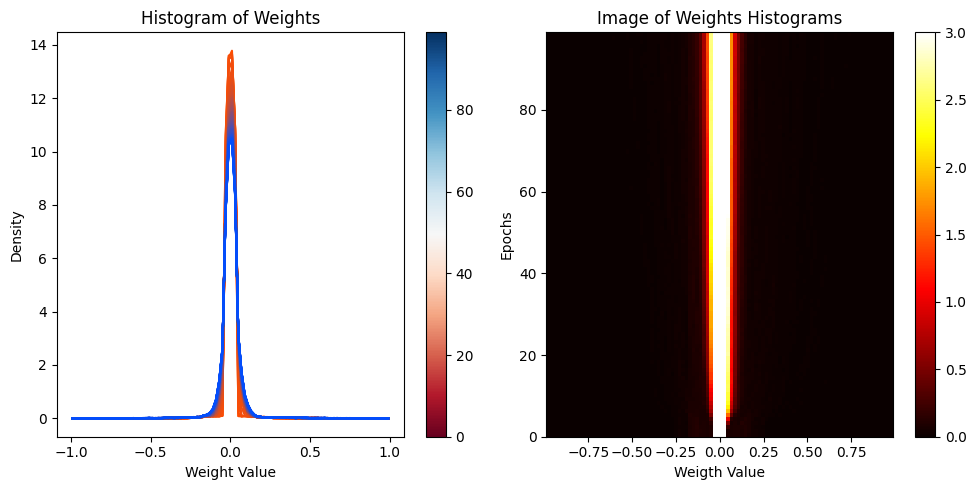

In [48]:
fig, ax = plt.subplots(1,2,figsize = (10,5))

for i in range(hist_y.shape[0]):
  ax[0].plot(hist_x, hist_y[i,:], color = [1 - i/100, .3, i/100])

ax[0].set_xlabel('Weight Value')
ax[0].set_ylabel('Density')
ax[0].set_title('Histogram of Weights')
sm1 = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=0, vmax=hist_y.shape[0]-1))
plt.colorbar(sm1, ax=ax[0])

im = ax[1].imshow(hist_y, vmin = 0, vmax = 3, extent = [hist_x[0], hist_x[-1], 0, 99], aspect = 'auto', origin = 'lower', cmap = 'hot')
ax[1].set_title('Image of Weights Histograms')
ax[1].set_xlabel('Weigth Value')
ax[1].set_ylabel('Epochs')
plt.colorbar(im, ax=ax[1])

plt.tight_layout()
plt.show()